In [4]:
import pandas as pd
import torchxrayvision as xrv
import numpy as np
import cv2
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from collections import Counter
import torchvision
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torch.optim import Adam,lr_scheduler
import time
import copy
from tqdm import tqdm
from funciones_aux import *
from PIL import ImageOps,Image
import glob

In [5]:
# try:
        
#     my_route = '../../OneDrive/Documents/Documentos/physionet.org/files/mimic-cxr/2.0.0'
#     os.chdir(my_route) 
# except FileNotFoundError:
#     pass

In [6]:
normal = glob.glob('./normal/*')
pneumonia = glob.glob('./pneumonia/*')

normal  = [nor for nor in normal if nor.find('txt')==-1]
pneumonia = [pn for pn in pneumonia if pn.find('txt')==-1]
total = normal+pneumonia


In [7]:
pathcleaned = lambda x:'./'+''.join(x.split('/')).split('\\')[0][1:]+'/'+''.join(x.split('/')).split('\\')[1]
df = pd.DataFrame({'path':total})
df['label'] = df.path.apply(lambda x:''.join(x.split('/')).split('\\')[0][1:])
df['path_x'] =  df.path.apply(pathcleaned)
df['Pneumonia'] = df.label.apply(lambda x: 0 if x=='normal' else 1)

In [8]:
Counter(df.Pneumonia)

Counter({0: 3629, 1: 4292})

### 2. Initialize data dividing in train validation and test

In [9]:
def concatsplit(X,y):
    '''
    Concat the datframes
    '''
    return pd.concat([X,y],axis=1)
def split(X,y,random_state = 8):
    '''
    Split the dataframe in train and test
    '''
    return train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

def split_(X,y):
    '''
    Split and concat dataframes
    '''
    # Split procedure
    X_train, X_val, y_train, y_val  = split(X, y)
    X_val, X_test, y_val, y_test = split(X_val, y_val)
    # Concatenation procedure
    train_df = concatsplit(X_train,y_train)
    val_df = concatsplit(X_val,y_val)
    test_df = concatsplit(X_test,y_test)
    return [train_df,val_df,test_df]


In [10]:
# df = pd.read_csv(f'./dicom_labels.csv')
# ### Look for images that 
# df_ = df[df.isNone==False]
# pneumonia_df = df_[(df_['No Finding'] == 1) | (df_.Pneumonia==1)]
# pneumonia_df.loc[pneumonia_df['No Finding'] ==1,'Pneumonia'] = 0
# # # pneumonia_df = pneumonia_df.fillna(0)
# pneumonia_df.Pneumonia = pneumonia_df.Pneumonia.astype('int64')
# # # # 2. Are AP or PA image in view position perspective
# pneumonia_df = pneumonia_df[(pneumonia_df.ViewPosition=='AP') | (pneumonia_df.ViewPosition=='PA')]
# pneumonia_df_ = pneumonia_df[['subject_id','study_id','dicom_id','path_x','Pneumonia','ViewPosition']]

# '''
# # Train test split
# # '''
# pneumonia_df_ = pneumonia_df_[pneumonia_df_.path_x!='files/p10/p10012292/s51979091/1fb53d30-20a85527-b71db2ae-28913b09-44ef76be.dcm']
y = df.pop('Pneumonia')
X = df
[train_df,val_df,test_df] = split_(X,y)
# '''
# Weight class 
# '''
# weight =  dict(Counter(train_df.Pneumonia))
# n  = sum(weight.values())
# weight = {key:prop/n for (key,prop) in weight.items()}

In [11]:
train_df

,path,label,path_x,Pneumonia
3188,./normal\patient35368_000.jpg,normal,./normal/patient35368_000.jpg,0
5660,./pneumonia\patient19258_000.jpg,pneumonia,./pneumonia/patient19258_000.jpg,1
3020,./normal\patient34413_000.jpg,normal,./normal/patient34413_000.jpg,0
2534,./normal\patient31923_000.jpg,normal,./normal/patient31923_000.jpg,0
5326,./pneumonia\patient18766_000.jpg,pneumonia,./pneumonia/patient18766_000.jpg,1
...,...,...,...,...
7276,./pneumonia\patient38848_000.jpg,pneumonia,./pneumonia/patient38848_000.jpg,1
4708,./pneumonia\patient13928_000.jpg,pneumonia,./pneumonia/patient13928_000.jpg,1
2449,./normal\patient31481_000.jpg,normal,./normal/patient31481_000.jpg,0
212,./normal\patient17395_000.jpg,normal,./normal/patient17395_000.jpg,0


In [7]:
# df = pd.concat([train_df,val_df,test_df],axis = 0)
Counter(test_df.Pneumonia)

Counter({1: 387, 0: 327})

In [8]:
Counter(val_df.Pneumonia)

Counter({0: 762, 1: 901})

### 3.Pytorch
Pytorch is an open source framework written in pytorch used in deep learning fields. We will use it to provide a CNN classification of chest x ray pathologies

In [9]:
os.environ['CUDA_VISIBLE_DEVICES']='0' # pick GPU to use
typedevice = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(typedevice)
print(f'Using {device} device')

Using cpu device


#### 3.1 Definition of the dataset

#### 3.2 Random Augmentation (transforming and manipulating the dataset)
The transformations that we make before inputting on to the train model:
- Applying CLAHE equalization
- Resize the image to 250x250 resolution
- Crop the image to the center 
- Map to a tensor object to run the data in gpu device

In [10]:
class XRayDataset(Dataset):
                '''
                Dataset Class of the images
                '''

                def __init__(self, csvfile, transform=None, target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))):
                    '''
                    @param csvfile (pd.DataFrame) Dataframe where we get the information of input and output parameters
                    @param transform (Transforms) Module to generate transformations on input data
                    @param target_transform (Transforms) Module to generate transformations on target data
                    '''
                    self.img_labels = csvfile 
                    self.transform = transform
                    self.target_transform = target_transform
                def check4d(self,image):
                  '''
                  Check if the image has 4 dimensions
                  '''
                  if image.shape[0]==4:
                    return np.expand_dims( image.numpy()[0,...],0)
                  elif image.shape[0]==1:
                    return image
                  else:
                    print('Something weird is happening')
                '''
                This generator returns the length of the dataset
                '''
                def __len__(self):
                    return len(self.img_labels)
                '''
                And this return the input and output terms returned 
                '''
                def __getitem__(self, idx):
                    img_path = self.img_labels.path.iloc[idx]
                    image = ImageOps.grayscale(Image.open(img_path))
                    # ### Check image 4d
                    # image = self.check4d(image)
                    # image = self.clahe.apply(np.array(image))
                    # image = Image.fromarray(image)
                    # label = np.array(self.img_labels.label_num.iloc[idx])
                    label = self.img_labels.Pneumonia.iloc[idx]
                    if self.transform:
                        image = self.transform(image)
                    if self.target_transform:
                        label = self.target_transform(label)
                    return image,label
def createdataset(*args,**kwargs):
        '''
        Creates the dataset of the model in a Dataset object
        @param df (pd.DataFrame) :dataframe of the model
        @param transform (Sequential|Transforms)  :module generally used to perform random Augmentation on the input tensor or different transformations
        @param target_transform (Transforms) :module module generally used to perform random Augmentation on the target tensor if specified

        '''
        return XRayDataset(*args,**kwargs)
def createdatasets(train_df,val_df,test_df):
        '''
        Create the datasets with the transformations
        '''
        '''
        Transformation with torchxrayvision transforms
        '''
        train_transform = torchvision.transforms.Compose([transforms.Resize(224), # maybe better to factor out resize step
            transforms.CenterCrop(224),
            transforms.ToTensor()])

        valid_transform = torchvision.transforms.Compose([transforms.Resize(224), # maybe better to factor out resize step
            transforms.CenterCrop(224),
            transforms.ToTensor()])
        test_transform = torchvision.transforms.Compose([transforms.Resize(224), # maybe better to factor out resize step
            transforms.CenterCrop(224),
            transforms.ToTensor()])
        '''
        Dataset Loading with random Augmentation
        '''
        train_dataset = createdataset(train_df,transform=train_transform,target_transform=None)
        validation_dataset = createdataset(val_df,transform=valid_transform,target_transform=None)
        test_dataset = createdataset(test_df,transform=test_transform,target_transform = None)
        return train_dataset,validation_dataset,test_dataset

In [11]:
train_dataset,validation_dataset,test_dataset = createdatasets(train_df,val_df,test_df)

len(train_dataset)

5544

#### 3.3 Transfer Learning
Before training the neural network we want to train we are going to take a pretrained neural network as base_model to start since a good match point.
To make the transfer learning approach we are going to take pretrained weights from chest x ray images from torchxrayvision framework.
The github framework is from the following page:
https://github.com/mlmed/torchxrayvision

In [12]:
def definemodel(use_summary = True,weights = "densenet121-res224-mimic_nb"):
        '''
        Definition of the model
        '''
        ## Load the mdodel
        model = xrv.models.DenseNet(weights=weights)
        ### Moodifications of the model
        model.op_threshs = None # prevent pre-trained model calibration
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential( nn.Linear(in_features=1024, out_features=2),torch.nn.LogSoftmax(dim=1)) #  Change the linear layer since 18 outputs to 2 
        model = model.to(device)
        if use_summary:
            summary(model,(1,224,224))
        return model
model = definemodel()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

#### 3.5 Optimization arguments
We stablish the configuration arguments to train the model.
The training is based on a take and test effort but taking into account that.
- The more are the parameters in proportion to the data experience you input to the model, the more possibility you have to overfit the data.
- The less the ratio parameters vs data you have the more possibility your model tends to be underfitted.
- Greater batch size implies having more directed convergence but more effort to make backward propagation batch step.
- Lower batch size implies less directed convergence but less effort to make backward propagation in each batch step.


In [13]:
def data_pin(dataset,**kwargs):
        '''
        Dataset already pinned and collate
        '''
        return DataLoader(dataset,**kwargs)
def configure_performance_data(train_dataset,validation_dataset,test_dataset,pin_memory = True,n_workers = None,prefecth_factor = 3,batch_size = 16):
       '''
       Configure the dataset for model peformance
       '''
       train_data_loader = data_pin(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=pin_memory,num_workers = n_workers//2,prefetch_factor = prefecth_factor)
       valid_data_loader = data_pin(validation_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory,num_workers = n_workers//2,prefetch_factor = prefecth_factor)
       test_dataloader = data_pin(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory,num_workers = n_workers-1,prefetch_factor = prefecth_factor)
       return train_data_loader,valid_data_loader,test_dataloader


In [14]:
torch.backends.cudnn.benchmark = True
# Batch of data you take for each training step
batch_size = 12
# N_workers on the cpu
n_workers = 1
# Type of memory pinning you use
pin_memory = False
train_data_loader = data_pin(train_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
valid_data_loader = data_pin(validation_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
test_dataloader = data_pin(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# Size of training | validation and test set
test_data_size = len(test_dataset); valid_data_size = len(validation_dataset);train_data_size = len(train_dataset)
# Define Optimizer and Loss Function
# loss_func = nn.NLLLoss().to(device)
# optimizer = Adam(model.parameters(),lr=0.0000375)
# # Learning rate scheduler | change by a factor of 0.1 per patience steps
# patience = 3
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=patience ,factor=0.1)

#### 3.6 Training model
This part executes the training step where the model acquires experience to be evaluated afterwards.

In [24]:
import plotly.express as px
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss





def train_and_validate(model, loss_criterion, optimizer, epochs=25,path = './results/checkpoint.pt',lr_scheduler = None):
    '''
    Function to train and validate
    Parameters
        :param model (torch.nn.Model): Model to train and validate
        :param loss_criterion (torch.nn.Loss): Loss Criterion to minimize
        :param optimizer  (torch.nn.optimizer): Optimizer for computing gradients
        :param epochs int: Number of epochs (default=25)
        :param path (str): path where the model must be saved
        :param lr_scheduler (torch.nn.scheduler) : change rate in learning rate
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    # Use of Early Stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True,path = path)
    # For each of the epochs
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        # For each of the batches
        for i, (inputs,labels) in enumerate(tqdm(train_data_loader,0)):
            # X,y to cuda device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass - compute outputs on input data using the model    
            outputs = model(inputs)
            # Computing the loss function
            loss = loss_criterion(outputs, labels)  
            # Backward propagation
            loss.backward()
            # Update the optimizer 
            optimizer.step()
            optimizer.zero_grad()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Get the predictions which maximizes the element of outputs vector
            ret, predictions = torch.max(outputs.data, 1)
            # Sum the correct counts
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            ## Printing out info (deprecated)
            # print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            # Validation loop
            for j, (inputs,labels) in  enumerate(valid_data_loader):
            
               
                # X,y to cuda device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                # Computing the loss function
                loss = loss_criterion(outputs, labels)
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)
                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size
        
        # Pass to next scheduler
        lr_scheduler.step(avg_valid_loss)
        # Early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100))
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
    epoch_end = time.time()
    print("Time: {:.4f}s".format( epoch_end-epoch_start))
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(path))
    return model, history
def stackhistory(history):
    '''
    Stack historical response
    @ param history (list of lists) : list of information got in the model (losses,precision,fbeta,...)
    '''
    return np.hstack((np.array(history),np.array([i for i in range(1,len(history)+1)])[:,None]))
def plothistory(history):
    '''
    Plot the history of the model
    '''
    history = stackhistory(history)
    history = pd.DataFrame(data = history,columns = ['train_loss','val_loss','train_acc','val_acc','epochs'])
    fig = px.line(history, x='epochs', y="val_loss",width=900,height=800)
    fig.data[0].name= "val_loss"
    fig.update_traces(showlegend=True)
    fig.add_scatter(x=history['epochs'], y=history['train_loss'],name = "train_loss")
    fig.show()
    

In [25]:
# model, history = train_and_validate(model, loss_func, optimizer, path = './checkpoint_ch.pt', epochs=25,lr_scheduler = lr_scheduler) 

In [26]:

# torch.backends.cudnn.benchmark = True
# use_summary = False
# # Batch of data you take for each training step
# batch_size = 12
# # N_workers on the cpu
# n_workers = 1
# # Type of memory pinning you use
# pin_memory = False
# train_data_loader = data_pin(train_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# valid_data_loader = data_pin(validation_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# test_dataloader = data_pin(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# # Size of training | validation and test set
# test_data_size = len(test_dataset); valid_data_size = len(validation_dataset);train_data_size = len(train_dataset)
# # Define Optimizer and Loss Function
# loss_func = nn.NLLLoss().to(device)
# # Learning rate scheduler | change by a factor of 0.1 per patience steps
# patience = 3

# def trainmodels(lr =4.090909090909091e-05,
#                 factor = 0.1 ,
#                 epochs = 25,
#                 use_summary = None,
#                 ckpoints = ['densenet121-res224-all','densenet121-res224-rsna','densenet121-res224-nih','densenet121-res224-pc','densenet121-res224-chex','densenet121-res224-mimic_ch'],
#                 ):
#         '''
#         For loop to train several models
#         '''
#         histories = []
#         for weights in ckpoints:
#             model = definemodel(use_summary=use_summary,weights=weights)
#             optimizer = Adam(model.parameters(),lr=lr)
#             scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=patience ,factor=factor)
#             base_name = weights.split('-')[-1]
#             path = f'./{base_name}.pt'
#             history = train_and_validate(model, loss_func, optimizer, path = path, epochs=epochs,lr_scheduler = scheduler) 
#             histories.append(history[1])
#         return histories
# histories = trainmodels()

# import pickle
# with open('historires.pickle', 'wb') as f:
#     pickle.dump(histories, f)

In [1]:
import pickle
with open('../models/pickles/opt_bin_thresh.pickle', 'rb') as f:
    results_ = pickle.load(f)

c:\Users\Pablo\anaconda3\envs\mlimage\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Pablo\anaconda3\envs\mlimage\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Pablo\anaconda3\envs\mlimage\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Pablo\anaconda3\envs\mlimage\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import pandas as pd
pd.DataFrame(results_)

,thresholds,AUCs,models,opt_thresh,accuracy,precision,recall,VPN,specifity,f1_score
0,threshold accuracy precision recall ...,0.986922,densenet121-res224-all,0.350,0.948179,0.958115,0.945736,0.936747,0.951070,0.951886
1,threshold accuracy precision recall ...,0.985863,densenet121-res224-rsna,0.450,0.941176,0.950392,0.940568,0.930514,0.941896,0.945455
2,threshold accuracy precision recall ...,0.983951,densenet121-res224-nih,0.550,0.936975,0.940722,0.943152,0.932515,0.929664,0.941935
3,threshold accuracy precision recall ...,0.985350,densenet121-res224-pc,0.525,0.939776,0.943299,0.945736,0.935583,0.932722,0.944516
4,threshold accuracy precision recall ...,0.988913,densenet121-res224-chex,0.250,0.952381,0.937965,0.976744,0.971061,0.923547,0.956962
5,threshold accuracy precision recall ...,0.977076,densenet121-res224-mimic_ch,0.325,0.932773,0.926952,0.950904,0.940063,0.911315,0.938776


In [27]:
import pickle 
with open('histories.pickle', 'rb') as f:
    histories = pickle.load(f)
for history in histories:
    plothistory(history=history)

#### 3.7 Evaluating the performance
Once the model is trained, we are going to evaluate the performance of the model trained

In [20]:
def test_model_ours(model,test_dataloader,numClasses = 2):
    '''
    Code to evaluate the model performance
    @param model (torch.nn.Model) : model already trained to be tested 
    @param test_dataloader (torch.nn.DataLoader): object to store the dataset on pytorch
    @numClasses (int): number of classes of the target output (default 2)
    '''
    # We put the model in evaluation mode
    model.eval()   
    # We initialize the variables where the labels and predictions are going to be stored 
    outputs_m=np.zeros((test_data_size,2),dtype=np.float)
    labels_m=np.zeros((test_data_size,),dtype=np.int)
    contSamples=0
    test_acc = 0.0        
    # For each test batch size
    for j, (inputs,labels) in  enumerate(test_dataloader):
                    # X,y to cuda device
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # Batch size
                    batchSize = inputs.shape[0]
                    
                    # Forward pass of the model 
                    with torch.torch.no_grad():
                            outputs = model(inputs)
                            _, predictions = torch.max(outputs.data, 1)
                    # Count times the model has been performed well 
                    correct_counts = predictions.eq(labels.data.view_as(predictions))
                    # We take exponential of the logarithm to get the exact probabilty
                    outputs_m [contSamples:contSamples+batchSize,...]=np.exp(outputs.data.cpu().numpy())
                    labels_m [contSamples:contSamples+batchSize,...]=labels.cpu().numpy()
                    # Batch counter
                    contSamples+=batchSize
                    # Convert correct_counts to float and then compute the mean
                    acc = torch.mean(correct_counts.type(torch.FloatTensor))
                    # Compute total accuracy in the whole batch and add to valid_acc
                    test_acc += acc.item() * inputs.size(0)
    ### Average accuracy of the batches
    acc_mean = test_acc/test_data_size
    return outputs_m,labels_m,acc_mean
def roc_(model,val_ds,modelname='VGG16'):
      '''
      Return the roc curve of the dataframe
      @param model (torch.nn.Model) : model of tensorflow or pytorch to be evaluated
      @param val_ds (dataframe) : validation or test set to evaluate
      @param modelname (str) : name of the model to output on visualizations
      '''
      curva_roc( y_val_covid,y_pred_covid, epochs = epochs, model_name = modelname)
      return  y_val_covid, y_pred_covid
def ev_metrics(y_pred_covid,y_val_covid,threshold =0.5):
    '''
    Evaluate the metrics 
    @param y_pred_covid  (list): predicted as covid
    @param y_true_covid  (list): true as covid
    '''
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    fpr, tpr, thresholds_keras = roc_curve(y_val_covid, y_pred_covid)
    AUC = auc(fpr, tpr)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    make_confusion_matrix(y_val_covid,y_pred_covid, threshold = threshold, cmap = 'YlOrRd', group_names=group_names,)
    threshold = list(map(lambda x: x/1000.0, range(0, 1000, 25)))
    cols = ['threshold', 'accuracy', 'precision', 'recall', 'VPN', 'specifity','f1_score' ]
    index= np.arange(len(threshold))
    opt_thres=pd.DataFrame(index=index, columns = cols)
    for i in range(len(list(threshold))):
        threshold = threshold
        y_pred2 = (y_pred_covid > threshold[i])
        matrix = confusion_matrix(y_val_covid, y_pred2)
        cf = pd.DataFrame(matrix, range(2), range(2))
        cf = cf.to_numpy()
        accuracy  = np.trace(cf) / float(np.sum(cf))
        precision = cf[1,1] / sum(cf[:,1])
        recall    = cf[1,1] / sum(cf[1,:])
        VPN       = cf[0,0] / sum(cf[:,0])
        specifity = cf[0,0] / sum(cf[0,:])
        f1_score  = 2*precision*recall / (precision + recall)
        opt_thres.loc[i] = pd.Series({'threshold':threshold[i], 'accuracy':accuracy, 'precision':precision, 'recall' : recall,
                                      'VPN':VPN, 'specifity':specifity,'f1_score':f1_score })
    opt_thres.plot(x='threshold', y=['precision', 'recall', 'accuracy'])
    #plt.title('Búsqueda threshold óptimo')
    plt.show()
    return opt_thres,AUC

'''
Wrapper function
'''
def evaluateperformance(PATH,model,test_dataloader,threshold = 0.525,model_name = 'pytorch_model'):
    '''
    Evaluate the performance of a model 
    @param PATH (str): path where the checkpoint of the model is already save
    @param model (torch.nn.module): model architecture you want to use
    @param test_dataloader (torch.nn.DataLoader): test dataloader
    @param threshold (float): frontier to decide if the class is classified well or bad
    @param model_name (str): name of the model to display
    '''
    # Load the model
    try:
        model.load_state_dict(torch.load(f'{PATH}'))
    except RuntimeError:
        pass
    # Evaluate roc curve of the model tested
    outputs_m,labels_m,acc_mean = test_model_ours(model,test_dataloader)
    curva_roc(labels_m,outputs_m[:,1], epochs = 25, model_name = model_name)
    # Evaluating metrics for some threshold
    opt_thres,AUC = ev_metrics(outputs_m[:,1],labels_m,threshold =threshold)
    return opt_thres,AUC

def definemodel(use_summary = False,weights = "densenet121-res224-mimic_nb"):
        '''
        Definition of the model
        '''
        ## Load the mdodel
        model = xrv.models.DenseNet(weights=weights)
        ### Moodifications of the model
        model.op_threshs = None # prevent pre-trained model calibration
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential( nn.Linear(in_features=1024, out_features=2),torch.nn.LogSoftmax(dim=1)) #  Change the linear layer since 18 outputs to 2 
        model = model.to(device)
        if use_summary:
            summary(model,(1,224,224))
        return model

In [21]:
ckpoints = ['densenet121-res224-all','densenet121-res224-rsna','densenet121-res224-nih','densenet121-res224-pc','densenet121-res224-chex','densenet121-res224-mimic_ch']


In [23]:
import os
os.getcwd()

'c:\\Users\\Pablo\\Desktop\\ML APPLIED TO  MEDICAL IMAGE AND REPORT DOCS\\notebooks'

In [ ]:
import pickle
with open('../models/pickles/opt_bin_thresh.pickle', 'rb') as f:
    results_ = pickle.load(f)

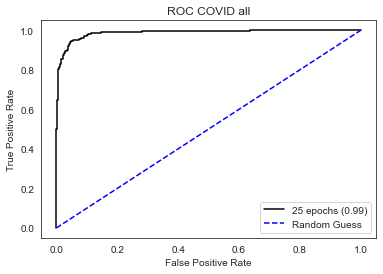

Confusion Matrix with threshold =  0.525


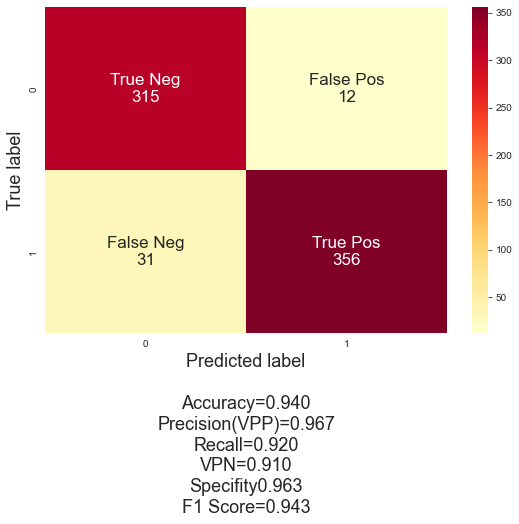

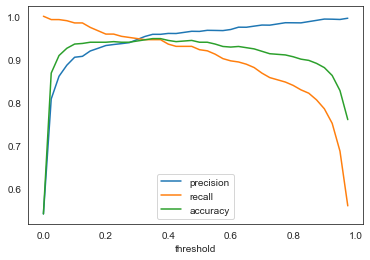

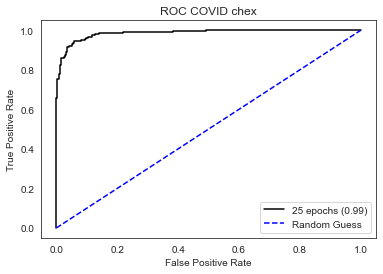

Confusion Matrix with threshold =  0.525


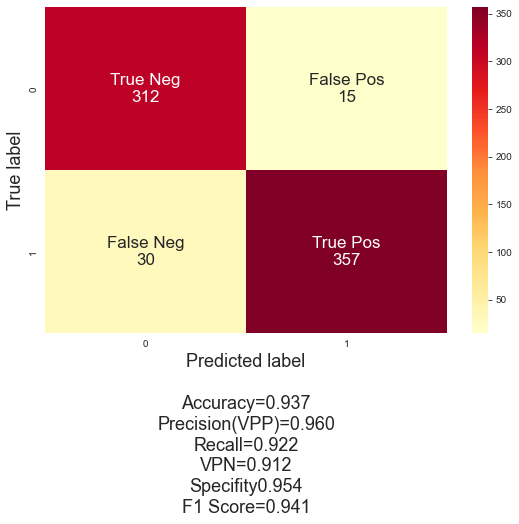

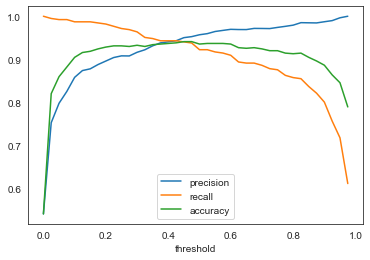

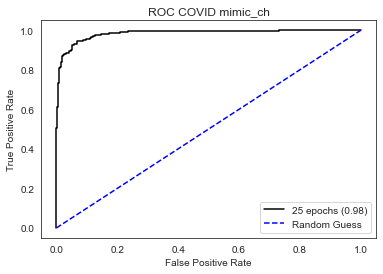

Confusion Matrix with threshold =  0.525


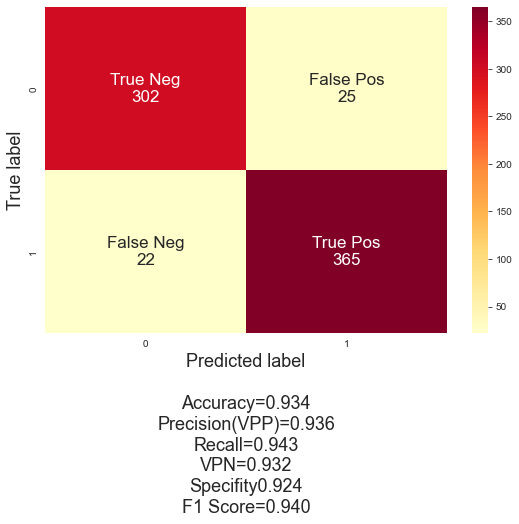

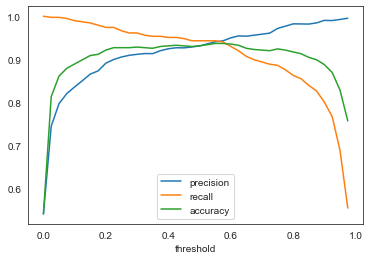

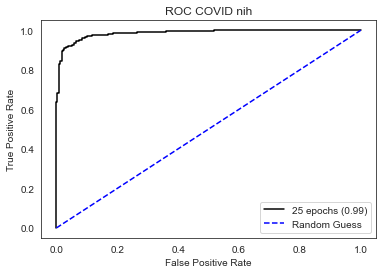

Confusion Matrix with threshold =  0.525


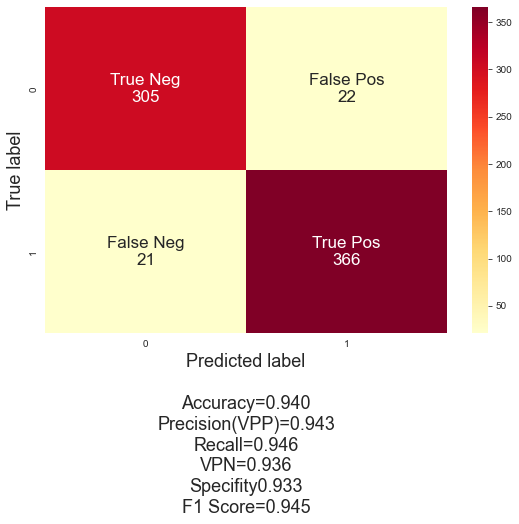

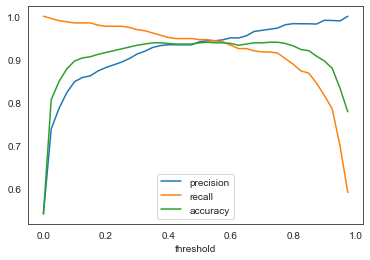

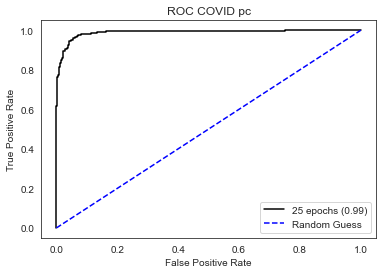

Confusion Matrix with threshold =  0.525


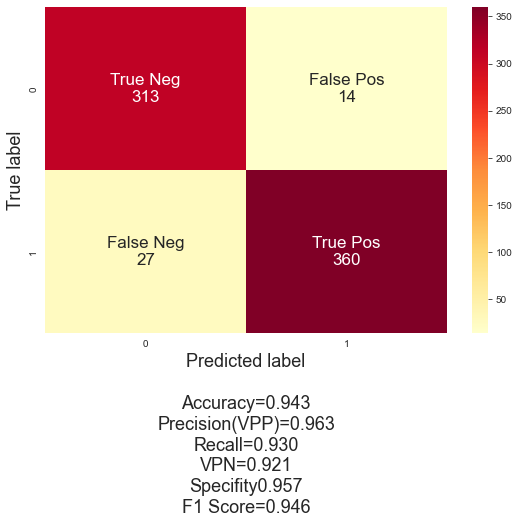

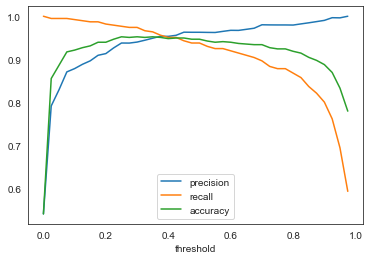

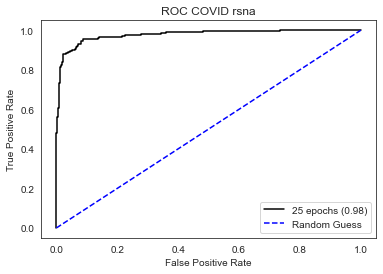

Confusion Matrix with threshold =  0.525


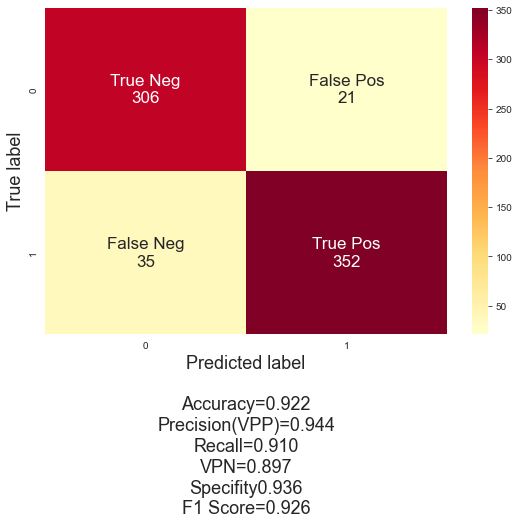

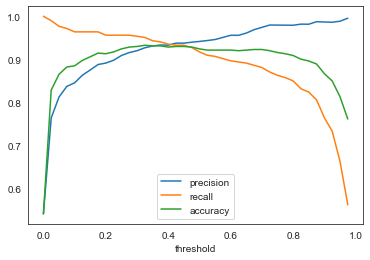

In [24]:
results_ = {'thresholds': [],'AUCs':[]}
for (model_ ,weights) in zip(os.listdir('../models/checkpoints/'),sorted(ckpoints)):
    model = definemodel(weights=weights,use_summary=False)
    PATH = f'../models/checkpoints/{model_}'
    model_name = model_.split('.pt')[0]
    
    opt_thres,AUC = evaluateperformance(PATH,model,test_dataloader,threshold = 0.525,model_name = f'{model_name}')
    results_['thresholds'].append(opt_thres)
    results_['AUCs'].append(AUC)

In [25]:
results_['models'] = ckpoints

In [29]:

import pickle
import pickle


# Store data (serialize)
with open('opt_bin_thresh.pickle', 'wb') as handle:
    pickle.dump(results_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
results_ = histories
metrics = ['opt_thresh','accuracy', 'precision', 'recall', 'VPN', 'specifity','f1_score']
for i in metrics:
    results_[i] = []

In [42]:
for i in range(len(results_['models'])):
    opt_df = results_['thresholds'][i].loc[results_['thresholds'][i]['f1_score'] == results_['thresholds'][i]['f1_score'].max(),:]
    print(opt_df)
    results_['opt_thresh'].append(opt_df.iloc[0].threshold)
    for j in metrics[1:]:
        results_[j].append(opt_df.iloc[0][j])

   threshold  accuracy precision    recall       VPN specifity  f1_score
14      0.35  0.948179  0.958115  0.945736  0.936747   0.95107  0.951886
15     0.375  0.948179  0.958115  0.945736  0.936747   0.95107  0.951886
   threshold  accuracy precision    recall       VPN specifity  f1_score
18      0.45  0.941176  0.950392  0.940568  0.930514  0.941896  0.945455
   threshold  accuracy precision    recall       VPN specifity  f1_score
22      0.55  0.936975  0.940722  0.943152  0.932515  0.929664  0.941935
   threshold  accuracy precision    recall       VPN specifity  f1_score
21     0.525  0.939776  0.943299  0.945736  0.935583  0.932722  0.944516
   threshold  accuracy precision    recall       VPN specifity  f1_score
10      0.25  0.952381  0.937965  0.976744  0.971061  0.923547  0.956962
   threshold  accuracy precision    recall       VPN specifity  f1_score
13     0.325  0.932773  0.926952  0.950904  0.940063  0.911315  0.938776


In [35]:
opt_df.columns

Index(['threshold', 'accuracy', 'precision', 'recall', 'VPN', 'specifity',
       'f1_score'],
      dtype='object')

In [43]:
pd.DataFrame(results_)

,thresholds,AUCs,models,opt_thresh,accuracy,precision,recall,VPN,specifity,f1_score
0,threshold accuracy precision recall ...,0.986922,densenet121-res224-all,0.350,0.948179,0.958115,0.945736,0.936747,0.951070,0.951886
1,threshold accuracy precision recall ...,0.985863,densenet121-res224-rsna,0.450,0.941176,0.950392,0.940568,0.930514,0.941896,0.945455
2,threshold accuracy precision recall ...,0.983951,densenet121-res224-nih,0.550,0.936975,0.940722,0.943152,0.932515,0.929664,0.941935
3,threshold accuracy precision recall ...,0.985350,densenet121-res224-pc,0.525,0.939776,0.943299,0.945736,0.935583,0.932722,0.944516
4,threshold accuracy precision recall ...,0.988913,densenet121-res224-chex,0.250,0.952381,0.937965,0.976744,0.971061,0.923547,0.956962
5,threshold accuracy precision recall ...,0.977076,densenet121-res224-mimic_ch,0.325,0.932773,0.926952,0.950904,0.940063,0.911315,0.938776


In [45]:
# Store data (serialize)
with open('opt_bin_thresh.pickle', 'wb') as handle:
    pickle.dump(results_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
results_['models']

['densenet121-res224-all',
 'densenet121-res224-rsna',
 'densenet121-res224-nih',
 'densenet121-res224-pc',
 'densenet121-res224-chex',
 'densenet121-res224-mimic_ch']

In [69]:
# Load data (deserialize)
with open('../models/pickles/opt_bin_thresh.pickle', 'rb') as handle:
    metadata = pickle.load(handle)

In [78]:

modelname = 'all'
# Load data (deserialize)
with open('../models/pickles/opt_bin_thresh.pickle', 'rb') as handle:
    metadata = pickle.load(handle)

modeldf = pd.DataFrame({'models':metadata['models'],
'opt_thresh':metadata['opt_thresh']})

opt_threshold = modeldf[modeldf['models'] == f'densenet121-res224-{modelname}']

In [81]:
results['thres']

array([0.35])

In [85]:
print(cv2.COLORMAP_AUTUMN)

0
